In [6]:
import torch
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
# TODO: model must be evaluated eval() after loading

DATE = '2020-07-20'#'2020-07-17'
EXP = '3_n_ep1000_l_ep100_lr0.001'
LOAD_DIR = Path('../saved_data') / DATE / EXP

# load general data
config = torch.load(LOAD_DIR / 'config')
total_rewards = torch.load(LOAD_DIR / 'tot_r')
times = torch.load(LOAD_DIR / 'running_times')

# load state data
versions = ['optim1', 'optim100']
states = dict()
plots = []
fig_count = 0
for version in versions:
    states.update({version: torch.load(LOAD_DIR / ('batch_states_' + version))})

<h2><center>plots for total reward </center></h2>

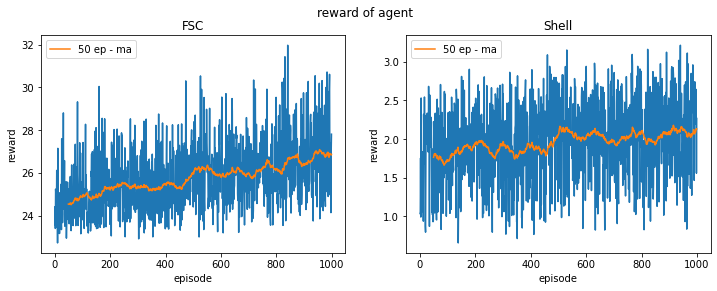

In [2]:
#plot total rewards of active agents and the rolling mean
window_width = 50

fig = plt.figure(fig_count, figsize=(12, 4))
plots.append(fig)
fig.suptitle('reward of agent')
ax = [fig.add_subplot(121), fig.add_subplot(122)]
fig_count += 1

for i, agt in enumerate(config['active_agents']):
    ma = pd.Series(total_rewards[agt]).rolling(window_width).mean()
    ax[i].plot(total_rewards[agt])
    ax[i].plot(ma, label='{} ep - ma'.format(window_width))
    ax[i].set_title(agt)
    ax[i].set_xlabel('episode')
    ax[i].set_ylabel('reward')
    ax[i].legend()

<h2><center>network analysis</center></h2>

In [27]:
# determine dead neurons by calculation of difference of weights
agents = [torch.load(LOAD_DIR / 'agents_init'), torch.load(LOAD_DIR / 'agents_optim100_ep1000')]
weights_diff = []
weights_diff.append(agents[0]['FSC'].get_networks()['Shell'][0].weight.detach().numpy() - \
                   agents[1]['FSC'].get_networks()['Shell'][0].weight.detach().numpy())
weights_diff.append(agents[0]['FSC'].get_networks()['Shell'][2].weight.detach().numpy() - \
                   agents[1]['FSC'].get_networks()['Shell'][2].weight.detach().numpy())
for i in weights_diff:
    print(np.where(np.all(np.isclose(i, 0), axis=1)))
    print(i)

(array([ 0,  1,  3,  5,  8, 10, 11], dtype=int64),)
[[ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 1.5910655e-02  1.4682978e-02  2.5774479e-02  1.4782518e-02]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 2.9336751e-02  2.8576165e-02  3.7561238e-02  1.4583707e-02]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 2.2490881e-02  2.3145158e-02  1.0319352e-02  8.3714426e-03]
 [-2.9226899e-02 -2.8401703e-02 -3.7819594e-02 -1.3977975e-02]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 2.4428487e-02  2.4842666e-02  2.1260917e-02 -1.3495833e-03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 3.6994219e-03  3.6993176e-03  3.6988929e-03  3.6991537e-03]
 [-1.7881393e-07 -4.7683716e-07 -1.3858080e-06 -5.0663948e-07]
 [-6.3103139e-03 -5.9515834e-03 -7.3454082e-03 -9.3808770e-03]
 [ 

Linear(in_features=16, out_features=3, bias=True)

<h2><center>plots for support</center></h2>

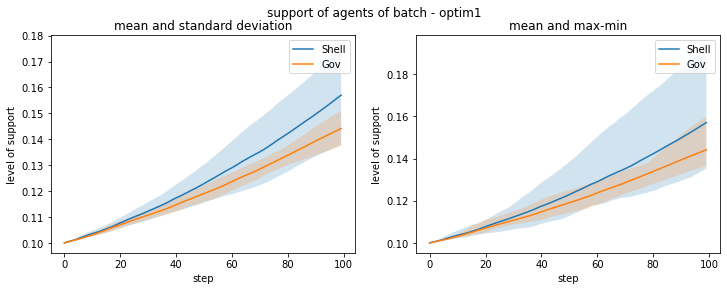

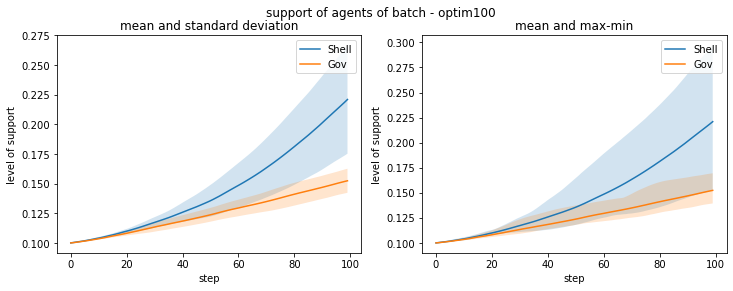

In [3]:
# loop over all versions
for version in versions:
    fig = plt.figure(fig_count, figsize=(12, 4))
    plots.append(fig)
    fig_count += 1
    # create two axes
    ax = [fig.add_subplot(121), fig.add_subplot(122)]
    # loop over each agent
    for key in ['Shell', 'Gov']:#config['agents']:#
        # calculate mean and std for support
        mean = states[version][key].mean(axis=0)[:, 0]
        std = states[version][key].std(axis=0)[:, 0]
        x = range(0, states[version][key].shape[1])
        # plot mean
        ax[0].plot(mean, label=key)
        ax[1].plot(mean, label=key)
        # plot std as an area
        ax[0].fill_between(x, mean+std, mean-std, alpha=0.2)
        # plot max and min as an area
        ax[1].fill_between(x, states[version][key].max(axis=0)[:, 0],
                           states[version][key].min(axis=0)[:, 0], alpha=0.2)
    # set some plot properties
    fig.suptitle('support of agents of batch - ' + version)
    ax[0].set_title('mean and standard deviation')
    ax[1].set_title('mean and max-min')
    for axis in fig.get_axes():
        axis.set_xlabel('step')
        axis.set_ylabel('level of support')
        axis.legend()

<h2><center>plots for resource assignment</center></h2>

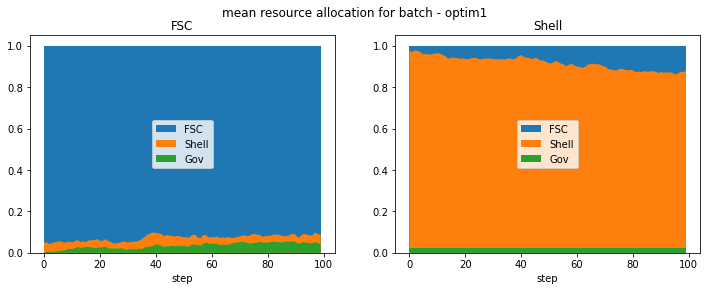

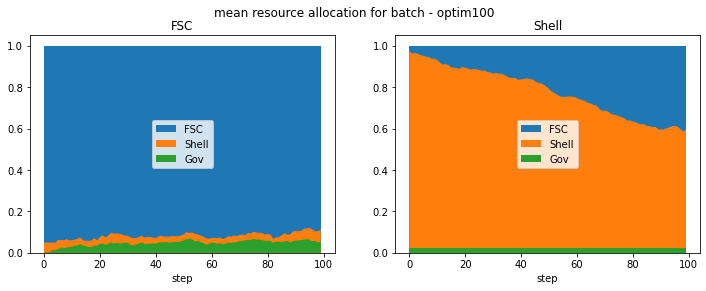

In [5]:
for version in versions:
    fig = plt.figure(fig_count, figsize=(12, 4))
    plots.append(fig)
    # create new axes
    ax = [fig.add_subplot(121), fig.add_subplot(122)]
    fig_count += 1

    for i, key in enumerate(config['active_agents']):
        # calculate mean of resource assignment to the different partner agents
        x = range(0, states[version][key].shape[1])
        fsc = states[version][key].mean(axis=0)[:, 1]
        shell = states[version][key].mean(axis=0)[:, 2]
        gov = states[version][key].mean(axis=0)[:, 3]

        # create stacked plots
        ax[i].stackplot(x, gov + shell + fsc)
        ax[i].stackplot(x, gov + shell)
        ax[i].stackplot(x, gov)
        ax[i].set_title(key)
        ax[i].set_xlabel('step')
        ax[i].legend(['FSC', 'Shell', 'Gov'], loc='center')
    fig.suptitle('mean resource allocation for batch - ' + version)

<h2><center>plots for support calculation</center></h2>

In [ ]:
# %matplotlib notebook
# %matplotlib inline
support_calc = dict()
par_agt = {'Shell': ['FSC', 'Gov'], 'Gov': ['FSC', 'Shell']}
for version in versions:
    # load data
    support_calc.update({version: torch.load(LOAD_DIR / ('support_calc_' + version))})
    # create figure and axis
    fig = plt.figure(fig_count, figsize=(12, 4))
    fig.suptitle('(mean of) shares of support calculation - ' + version)
    plots.append(fig)  
    fig_count += 1
    ax = [fig.add_subplot(121), fig.add_subplot(122)]
    
    for i, key in enumerate(support_calc[version].keys()):
        x = range(0, support_calc[version][key].shape[1])
        mean = support_calc[version][key].mean(axis=0)[:, :]               
#         ax[i].plot(mean[:,0], label='support before' ) # oder raus
        ax[i].plot(mean[:,1], label= par_agt[key][0] + ' (partner)')
        ax[i].plot(mean[:,2], label= par_agt[key][1] + ' (partner)')
        ax[i].legend()
        ax[i].set_title(key)
    

In [ ]:
# support von Gov ist genau das gespiegelte von Shell
support_calc[version]['Gov'].mean(axis=0)[:,:][:,2] + support_calc[version]['Shell'].mean(axis=0)[:,:][:,2]

<h2><center>plots for shell reward calculation</center></h2>

In [ ]:
reward_shell = dict()
for version in versions:
    # load data
    reward_shell.update({version: torch.load(LOAD_DIR / ('reward_shell_calc_' + version))})
    fig = plt.figure(fig_count)
    fig_count += 1
    ax = fig.add_subplot(111)
    
    mean = reward_shell[version].mean(axis=0)[:, :]
    x = range(0, reward_shell[version].shape[1])
    
    # create stacked plots
    ax.stackplot(x, mean[:, 3] + mean[:, 2] + mean[:, 1])
    ax.stackplot(x, mean[:, 3] + mean[:, 2])
    ax.stackplot(x, mean[:, 3])
    
    # axis properties
    ax.legend(['own return', 'external spending', 'internal spending'])
    ax.set_title('mean of shares of discounted reward for Shell')

<h2><center>saving plots to pdf or svg</center></h2>

In [ ]:
plots

In [ ]:
plots[1].savefig((LOAD_DIR / (DATE + '_' + EXP + '_'  + versions[0] + '_support_calc' + '.pdf'))) # svg auch möglich

In [ ]:
plots[1]